In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import pandas as pd

2021-12-16 23:41:44.848475: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2021-12-16 23:41:51.243415: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2021-12-16 23:41:51.312356: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:1c:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-12-16 23:41:51.312390: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2021-12-16 23:41:51.319098: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2021-12-16 23:41:51.319153: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
2021-12-16 23:41:51.321561: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcufft.

### Load Dataset
image_path and captions

In [3]:
path = "../work/lab13-2/words_captcha/"
annotation_file = 'spec_train_val.txt'
spec = pd.read_csv(path + annotation_file, header=None, delim_whitespace=True, names=['image', 'caption'])
display(spec.head())
all_captions = []
all_images = []
for annotation in spec['caption']:
    caption = '<start> ' + ' '.join(str(annotation)) + ' <end>'
    all_captions.append(caption)
for image_name in spec['image']:
    img_path = path + image_name + '.png'
    all_images.append(img_path)
display(all_captions[:5])
display(all_images[:5])

,image,caption
0,a0,thus
1,a1,www
2,a2,tied
3,a3,ids
4,a4,jam


['<start> t h u s <end>',
 '<start> w w w <end>',
 '<start> t i e d <end>',
 '<start> i d s <end>',
 '<start> j a m <end>']

['../work/lab13-2/words_captcha/a0.png',
 '../work/lab13-2/words_captcha/a1.png',
 '../work/lab13-2/words_captcha/a2.png',
 '../work/lab13-2/words_captcha/a3.png',
 '../work/lab13-2/words_captcha/a4.png']

In [4]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(lower = False,
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(all_captions)
train_seqs = tokenizer.texts_to_sequences(all_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(all_captions)
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [5]:
# Find the maximum length of any caption in our dataset
# Calculates the max_length, which is used to store the attention weights
def calc_max_length(tensor):
    return max(len(t) for t in tensor)
max_length = calc_max_length(train_seqs)

### Preprocess
Arrange every data into same length by adding paddings
Data split

In [6]:
train_num = 100000
val_num = 20000
# Split Train / Validation
cap_train = cap_vector[:train_num]
cap_val = cap_vector[train_num:120000]
cap_test = cap_vector[120000:]
img_train = all_images[:train_num]
img_val = all_images[train_num:120000]
img_test = all_images[120000:]
display(img_train[:5])
display(cap_train[:5])
display([[tokenizer.index_word[i] for i in word] for word in cap_train[:5]])

['../work/lab13-2/words_captcha/a0.png',
 '../work/lab13-2/words_captcha/a1.png',
 '../work/lab13-2/words_captcha/a2.png',
 '../work/lab13-2/words_captcha/a3.png',
 '../work/lab13-2/words_captcha/a4.png']

array([[ 1,  8, 17, 16,  5,  2,  0],
       [ 1, 23, 23, 23,  2,  0,  0],
       [ 1,  8,  7,  3, 12,  2,  0],
       [ 1,  7, 12,  5,  2,  0,  0],
       [ 1, 25,  4, 15,  2,  0,  0]], dtype=int32)

[['<start>', 't', 'h', 'u', 's', '<end>', '<pad>'],
 ['<start>', 'w', 'w', 'w', '<end>', '<pad>', '<pad>'],
 ['<start>', 't', 'i', 'e', 'd', '<end>', '<pad>'],
 ['<start>', 'i', 'd', 's', '<end>', '<pad>', '<pad>'],
 ['<start>', 'j', 'a', 'm', '<end>', '<pad>', '<pad>']]

### Parameters

In [8]:
BATCH_SIZE = 32
BUFFER_SIZE = 5000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [9]:
def load_image(image_path, caption):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (256, 256))
    #img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, caption

### Tensorflow data for training

In [10]:
dataset = tf.data.Dataset.from_tensor_slices((img_train,cap_train))
dataset = dataset.map(load_image, 
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Model

In [11]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

## Encoder
I was trying to use VGG19 as the encoder model, but the time consumption was too much. Therefore, I modified into VGG16.
It reshaped the final convolutional layer into (None, 64, 152) instead of flattening in order to fit the decoder.
In this implementation, it speeds up and after connecting a dense layer with 1024 units, it reduces the loss.

In [12]:
import tensorflow.keras.layers as layers
from tensorflow import keras
input_ = tf.keras.Input(shape=(256, 256, 3))
#Encoder
# Block 1
x = layers.Conv2D(64, (3, 3), strides=(1, 1), activation='relu', padding='same', name='block1_conv1')(input_)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
# Block 2
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
# Block 3
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
#x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
# Block 4
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
#x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
# Block 5
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
#x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv4')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

#x = keras.layers.Flatten()(x)
x = layers.Reshape((-1, x.shape[3]), name='reshape1')(x)
x = layers.Dense(1024, activation='relu', name='Dense1')(x)
output_ = layers.Dense(embedding_dim, activation='relu', name='Dense2')(x)

encoder = keras.Model(input_, output_)

In [13]:
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [14]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [15]:
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [17]:
checkpoint_path = "../work/anyan_work/ckpts_lab13_2/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

### Checkpoint
Epoch starts from the previous restoration.

In [18]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    print(start_epoch)

32


In [25]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [27]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        #print(f"Target: {target.shape}")

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [28]:
EPOCHS = 50

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

#         if batch % 100 == 0:
#             print ('Epoch {} Batch {} Loss {:.4f}'.format(
#               epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

2021-12-16 17:56:30.634650: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 17:56:30.634725: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 17:56:30.634758: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 17:56:30.634773: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 17:56:34.735258: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 17:56:34.735299: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 17:56:34.735643: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 17:56:34.735654: W tensorflow/core/grappler/

Epoch 19 Loss 0.003893
Time taken for 1 epoch 577.4439911842346 sec



2021-12-16 18:06:08.075095: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 18:06:08.075148: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 18:06:08.075170: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 18:06:08.075180: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.


Epoch 20 Loss 0.001765
Time taken for 1 epoch 569.4556202888489 sec



2021-12-16 18:15:37.533033: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 18:15:37.533103: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 18:15:37.533138: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 18:15:37.533153: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.


Epoch 21 Loss 0.003293
Time taken for 1 epoch 569.3539252281189 sec



2021-12-16 18:25:06.885914: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 18:25:06.885955: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 18:25:06.885968: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 18:25:06.885974: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.


Epoch 22 Loss 0.001970
Time taken for 1 epoch 570.5095021724701 sec



2021-12-16 18:34:37.393446: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 18:34:37.393526: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 18:34:37.393562: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 18:34:37.393577: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.


Epoch 23 Loss 0.002351
Time taken for 1 epoch 570.3073267936707 sec



2021-12-16 18:44:07.701822: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 18:44:07.701895: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 18:44:07.701927: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 18:44:07.701940: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.


Epoch 24 Loss 0.002382
Time taken for 1 epoch 569.904670715332 sec



2021-12-16 18:53:37.604152: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 18:53:37.604189: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 18:53:37.604205: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 18:53:37.604210: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.


Epoch 25 Loss 0.002131
Time taken for 1 epoch 570.1758689880371 sec



2021-12-16 19:03:07.780390: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 19:03:07.780432: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 19:03:07.780445: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 19:03:07.780450: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.


Epoch 26 Loss 0.002582
Time taken for 1 epoch 570.3060412406921 sec



2021-12-16 19:12:38.089640: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 19:12:38.089677: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 19:12:38.089690: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 19:12:38.089696: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.


Epoch 27 Loss 0.001852
Time taken for 1 epoch 570.1321740150452 sec



2021-12-16 19:22:08.218818: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 19:22:08.218863: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 19:22:08.218880: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 19:22:08.218888: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.


Epoch 28 Loss 0.002020
Time taken for 1 epoch 569.213499546051 sec



2021-12-16 19:31:37.432971: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 19:31:37.433010: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 19:31:37.433024: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 19:31:37.433029: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.


Epoch 29 Loss 0.002025
Time taken for 1 epoch 570.0607945919037 sec



2021-12-16 19:41:07.493204: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 19:41:07.493254: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 19:41:07.493274: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 19:41:07.493283: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.


Epoch 30 Loss 0.001552
Time taken for 1 epoch 570.2273526191711 sec



2021-12-16 19:50:37.720219: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 19:50:37.720260: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 19:50:37.720273: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 19:50:37.720278: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.


Epoch 31 Loss 0.001093
Time taken for 1 epoch 570.4311623573303 sec



2021-12-16 20:00:08.153019: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 20:00:08.153070: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 20:00:08.153091: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 20:00:08.153100: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.


Epoch 32 Loss 0.001077
Time taken for 1 epoch 570.3007774353027 sec



2021-12-16 20:09:38.453893: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 20:09:38.453931: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 20:09:38.453946: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 20:09:38.453951: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.


Epoch 33 Loss 0.001740
Time taken for 1 epoch 569.7635915279388 sec



2021-12-16 20:19:08.216887: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 20:19:08.216940: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 20:19:08.216962: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 20:19:08.216972: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.


Epoch 34 Loss 0.000995
Time taken for 1 epoch 570.0913400650024 sec



2021-12-16 20:28:38.308541: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 20:28:38.308605: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 20:28:38.308633: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 20:28:38.308646: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.


Epoch 35 Loss 0.000906
Time taken for 1 epoch 569.8113946914673 sec



2021-12-16 20:38:08.119587: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 20:38:08.119628: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 20:38:08.119641: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 20:38:08.119647: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.


Epoch 36 Loss 0.001268
Time taken for 1 epoch 569.6148872375488 sec



2021-12-16 20:47:37.735497: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 20:47:37.735568: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 20:47:37.735612: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 20:47:37.735628: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.


Epoch 37 Loss 0.000703
Time taken for 1 epoch 570.0493588447571 sec



2021-12-16 20:57:07.784858: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 20:57:07.784937: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 20:57:07.784972: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 20:57:07.784988: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.


Epoch 38 Loss 0.002066
Time taken for 1 epoch 570.9102835655212 sec



2021-12-16 21:06:38.695836: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 21:06:38.695879: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 21:06:38.695896: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 21:06:38.695901: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.


Epoch 39 Loss 0.000943
Time taken for 1 epoch 572.4287388324738 sec



2021-12-16 21:16:11.126165: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 21:16:11.126205: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 21:16:11.126220: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 21:16:11.126226: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.


Epoch 40 Loss 0.001186
Time taken for 1 epoch 569.1825966835022 sec



2021-12-16 21:25:40.305828: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 21:25:40.305874: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 21:25:40.305894: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 21:25:40.305902: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.


Epoch 41 Loss 0.000785
Time taken for 1 epoch 570.2016704082489 sec



2021-12-16 21:35:10.508380: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 21:35:10.508451: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 21:35:10.508489: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 21:35:10.508504: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.


Epoch 42 Loss 0.001170
Time taken for 1 epoch 570.1168522834778 sec



2021-12-16 21:44:40.624267: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 21:44:40.624439: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 21:44:40.624465: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 21:44:40.624473: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.


Epoch 43 Loss 0.000732
Time taken for 1 epoch 569.7607069015503 sec



2021-12-16 21:54:10.389717: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 21:54:10.389794: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 21:54:10.389830: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 21:54:10.389846: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.


Epoch 44 Loss 0.000699
Time taken for 1 epoch 572.0484671592712 sec



2021-12-16 22:03:42.434023: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 22:03:42.434071: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 22:03:42.434086: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 22:03:42.434091: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.


Epoch 45 Loss 0.000724
Time taken for 1 epoch 572.7844560146332 sec



2021-12-16 22:13:15.217515: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 22:13:15.217556: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 22:13:15.217570: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 22:13:15.217576: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.


Epoch 46 Loss 0.000470
Time taken for 1 epoch 572.5208919048309 sec



2021-12-16 22:22:47.738654: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 22:22:47.738692: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 22:22:47.738708: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 22:22:47.738713: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.


Epoch 47 Loss 0.001130
Time taken for 1 epoch 570.8480975627899 sec



2021-12-16 22:32:18.587117: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 22:32:18.587169: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 22:32:18.587189: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 22:32:18.587198: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.


Epoch 48 Loss 0.000880
Time taken for 1 epoch 571.4459500312805 sec



2021-12-16 22:41:50.034651: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 22:41:50.034690: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 22:41:50.034705: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 22:41:50.034711: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.


Epoch 49 Loss 0.000485
Time taken for 1 epoch 572.3116445541382 sec



2021-12-16 22:51:22.350051: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 22:51:22.350106: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 22:51:22.350124: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2021-12-16 22:51:22.350130: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:153] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.


Epoch 50 Loss 0.001187
Time taken for 1 epoch 573.1168968677521 sec



### Plot
I accidentally ran the "loss_plot = []" cell again before continue training from the 18th checkpoint, so the plot doesn't show the loss before the very checkpoint. 0 represents the 18th epoch.

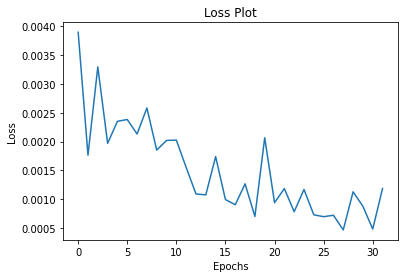

In [31]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [32]:
model_epoch = 0
latest = ckpt_manager.latest_checkpoint
if latest:
    model_epoch = int(latest.split('-')[-1])
    print(latest)
    ckpt.restore(latest)

../work/anyan_work/ckpts_lab13_2/ckpt-32


In [22]:
def load_test_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (256, 256))
    return img

In [41]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    img_tensor_val = tf.expand_dims(load_test_image(image), 0)
    # img_tensor_val = image_features_extract_model(temp_input)
    # img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    is_end = False

    for i in range(max_length):
        if is_end:
            result.append(tokenizer.index_word[0])
        else:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            # attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            predicted_id = tf.argmax(predictions[0]).numpy()
            result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            # return result, attention_plot
            is_end = True

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [42]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> p a s s <end>
Prediction Caption: p a s s <end> <pad> <pad>


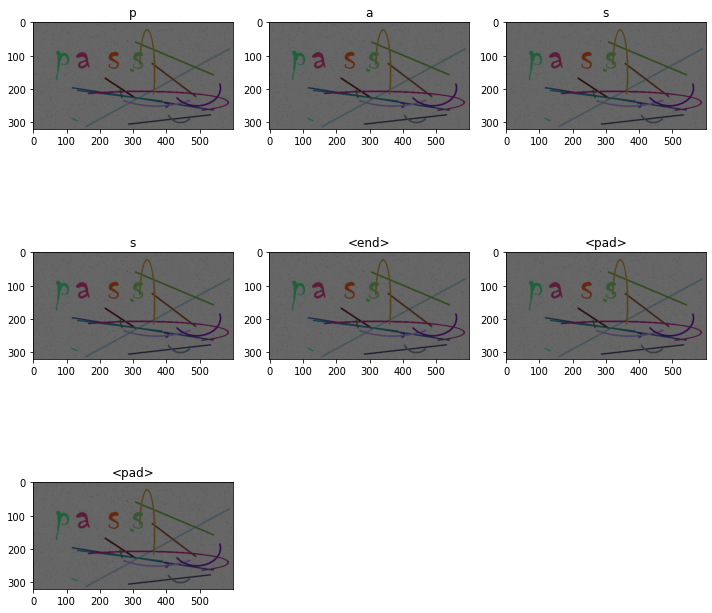

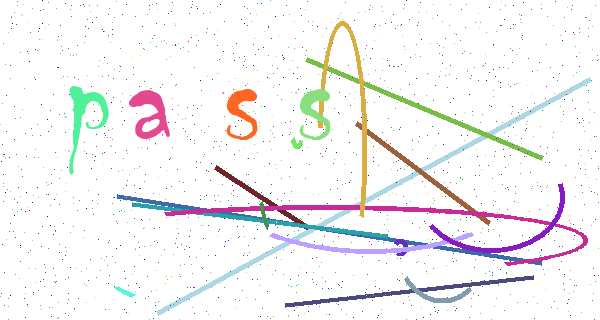

In [43]:
# captions on the validation set
rid = np.random.randint(0, len(img_val))
image = img_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
# opening the image

Image.open(img_val[rid])

### Caption
test on validation set

In [44]:
def predict(image):
    hidden = decoder.reset_state(batch_size=1)
    img_tensor_val = tf.expand_dims(load_test_image(image), 0)
    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])
    return result

def filter_tag(letter):
    tags = ['<start>', '<end>', '<pad>']
    if letter in tags:
        return False
    else:
        return True

#### latest checkpoint performance

In [45]:
from tqdm import tqdm
acc_num = 0
pbar = tqdm(range(len(img_val)))
for rid in pbar:
    image = img_val[rid]
    # print(f"Path: {image}")
    real_caption = [tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]]
    pred_caption = predict(image)

    real_caption = list(filter(filter_tag, real_caption))
    pred_caption = list(filter(filter_tag, pred_caption))
    # print(f"Real: {real_caption}, Pred: {pred_caption}")
    if real_caption == pred_caption:
        acc_num = acc_num + 1
    else:
        pass
        # print(f"Real: {real_caption}, Pred: {pred_caption}")
    pbar.set_description(f"Acc: {round((acc_num / (rid+1)) * 100, 2)}%")

print(f"Total Acc: {round((acc_num / len(img_val)) * 100, 2)}%")

Acc: 95.12%: 100%|██████████| 20000/20000 [20:52<00:00, 15.97it/s]

Total Acc: 95.12%


In [19]:
ckpt.restore("../work/anyan_work/ckpts_lab13_2/ckpt-28")

In [20]:
def predict(image):
    hidden = decoder.reset_state(batch_size=1)
    img_tensor_val = tf.expand_dims(load_test_image(image), 0)
    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])
    return result

def filter_tag(letter):
    tags = ['<start>', '<end>', '<pad>']
    if letter in tags:
        return False
    else:
        return True

#### lowest loss checkpoint performance (not enough time)

In [23]:
from tqdm import tqdm
acc_num = 0
pbar = tqdm(range(len(img_val)))
for rid in pbar:
    image = img_val[rid]
    # print(f"Path: {image}")
    real_caption = [tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]]
    pred_caption = predict(image)

    real_caption = list(filter(filter_tag, real_caption))
    pred_caption = list(filter(filter_tag, pred_caption))
    # print(f"Real: {real_caption}, Pred: {pred_caption}")
    if real_caption == pred_caption:
        acc_num = acc_num + 1
    else:
        pass
        # print(f"Real: {real_caption}, Pred: {pred_caption}")
    pbar.set_description(f"Acc: {round((acc_num / (rid+1)) * 100, 2)}%")

print(f"Total Acc: {round((acc_num / len(img_val)) * 100, 2)}%")

  0%|          | 0/20000 [00:00<?, ?it/s]2021-12-16 23:42:51.765650: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2021-12-16 23:42:52.245537: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2021-12-16 23:42:52.771755: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2021-12-16 23:42:53.174163: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
Acc: 98.04%:   3%|▎         | 613/20000 [00:42<22:14, 14.53it/s] 


KeyboardInterrupt: 

In [ ]:
from os import listdir
from os.path import isfile, join

file_list = [f for f in listdir(path) if isfile(join(path, f)) and f[-4:] == '.png']
test_full_path_list = [join(path, f) for f in file_list if isfile(join(path, f)) and int(f[1:-4]) >= 120000]
test_name_list = [f[:-4] for f in file_list if isfile(join(path, f)) and int(f[1:-4]) >= 120000]
print(len(test_full_path_list))
print(test_full_path_list[:5])
print(test_name_list[:5])

### Predict Testing data (cleared output accidentally, showed in another notebook)

In [ ]:
import csv
pbar = tqdm(range(len(test_full_path_list)))

with open('../work/anyan_work/ckpts_Lab13_2/Lab13-2_107081028.txt', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=' ')

    for rid in pbar:
        image = test_full_path_list[rid]
        pred_caption = predict(image)
      
        pred_caption = ''.join(list(filter(filter_tag, pred_caption)))
        row = [test_name_list[rid], pred_caption]

    # print(row)
        writer.writerow(row)